<div style="color:#F37021; font-size:150%; text-align:left; border-radius:5px">
    <h4><u> BIBLIOTECAS UTILIZADAS </u></h4>
</div>

In [1]:
import sqlite3

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import squarify

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import joblib

import warnings
warnings.filterwarnings("ignore")

<div style="color:#F37021; font-size:150%; text-align:left; border-radius:5px">
    <h4><u> CONECTAR AO BANCO DE DADOS </u></h4>
</div>

In [2]:
con = sqlite3.connect('../dados/desafio-tecnico.db')
cur = con.cursor()
print('\nConexão bem Sucedida\n')


Conexão bem Sucedida



In [3]:
cur.execute('SELECT name FROM sqlite_master WHERE type="table"')
print(f'\nTabelas contidas no banco de dados:\n\n{cur.fetchall()}\n')


Tabelas contidas no banco de dados:

[('accounts',), ('address',), ('levels',), ('charges',), ('transactions',), ('transaction_type',)]



<div style="color:#F37021; font-size:150%; text-align:left; border-radius:5px">
    <h4><u> TRATAR DADOS </u></h4>
</div>

**Para facilitar a visualização, manipularemos nossas tabela obtidas em formato de DataFrame:**

In [4]:
#criar dataframes
df_accounts = pd.read_sql_query(f'SELECT * FROM accounts', con)    
df_address = pd.read_sql_query(f'SELECT * FROM address', con)  
df_levels = pd.read_sql_query(f'SELECT * FROM levels', con)
df_charges = pd.read_sql_query(f'SELECT * FROM charges', con)
df_transactions = pd.read_sql_query(f'SELECT * FROM transactions', con)
df_transaction_type = pd.read_sql_query(f'SELECT * FROM transaction_type', con)

Possuímos dois tipos diferentes de tabela a serem trabalhadas. Dividiremos elas em **Tabelas Dimensão e Tabelas Fato**. A primeira traz **informações sobre características**, tendo caráter explicativo. Suas informações são únicas. Já na segunda temos os fatos, ou **acontecimentos, da empresa**, podendo, ou não, conter informações redundantes. Suas informações são complementadas com as informações da Tabela Dimensão.

Dividiremos então da seguinte forma:

**Tabelas Dimensão:**

- df_accounts
- df_address
- df_levels
- df_transaction_type

**Tabelas Fato:**

- df_charges
- df_transactions
<br>
<br>
<br>

<hr>

<br>
<br>
Vamos começar a trabalhá-las:
<br>
<br>

**1) Juntar as tabelas dimensão df_accounts, df_address e df_levels em um único df_dim:**

As tabelas dimensão df_address e df_levels são características relacionadas a tabela dimensão df_accounts. Para não termos todas estas informações espalhadas, criaremos um único df_dim contendo todas as características das contas de uma forma mais detalhada.

In [5]:
join_accounts_address_levels = '''
                                SELECT
                                    accounts.id,
                                    accounts.account_number,
                                    accounts.birth, 
                                    accounts.occupation,
                                    accounts.email,
                                    accounts.address_id,
                                    accounts.created_at AS created_account,
                                    address.state,
                                    address.city,
                                    address.created_at AS created_address,
                                    levels.level,
                                    levels.created_at AS created_level
                                FROM 
                                    accounts
                                LEFT JOIN address
                                    ON accounts.address_id = address.id
                                        LEFT JOIN levels
                                            ON accounts.account_number = levels.account_number
                               '''
df_dim = pd.read_sql(join_accounts_address_levels, con)

Pela descrição do problema, temos que em level, as contas são classificadas de acordo com a forma que é utilizada a plataforma. Contas que utilizam com maior consistência ou com grande potencial podem receber uma melhor classificação (A>B>C>D) e, caso seja identificado características suspeitas de fraude, a conta recebe uma classificação F e é descontinuada. Sendo assim, podemos aqui **criar uma característica booleana is_Fraud indicando se a conta é lícita ou ilícita**. Isso nos auxiliará posteriormente em análises e na criação de um **aprendizado supervisionado para classificação de contas**.

**Vamos então criar a característica is_Fraud:**

In [6]:
df_dim['is_Fraud'] = df_dim['level'].replace({'A':0, 'B':0, 'C':0, 'D':0, 'F':1})
df_dim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1029 non-null   int64  
 1   account_number   1029 non-null   int64  
 2   birth            1029 non-null   object 
 3   occupation       1029 non-null   object 
 4   email            1029 non-null   object 
 5   address_id       1029 non-null   int64  
 6   created_account  1029 non-null   object 
 7   state            1029 non-null   object 
 8   city             1029 non-null   object 
 9   created_address  1029 non-null   object 
 10  level            926 non-null    object 
 11  created_level    926 non-null    object 
 12  is_Fraud         926 non-null    float64
dtypes: float64(1), int64(3), object(9)
memory usage: 104.6+ KB


**Os valores faltantes em level, created_level e is_Fraud são sobre as contas que devemos classificar entre lícitas e ilícitas ao final do projeto.** Portanto, por hora, não nos preocuparemos com ela.

Podemos notar também que todas as informações referentes a datas estão com o formato de object. Vamos corrigir este formato para datetime, mais indicado para trabalhar estes dados:

In [7]:
aux = ['birth', 'created_account', 'created_address', 'created_level']
for coluna in aux:
    df_dim[coluna] = pd.to_datetime(df_dim[coluna])    
df_dim[aux].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   birth            1029 non-null   datetime64[ns]
 1   created_account  1029 non-null   datetime64[ns]
 2   created_address  1029 non-null   datetime64[ns]
 3   created_level    926 non-null    datetime64[ns]
dtypes: datetime64[ns](4)
memory usage: 32.3 KB


Pode ser que a idade seja uma informação mais relevante ao problema do que a data de nascimento em si. Para isso criaremos uma **coluna age contendo a idade dos clientes em 2022**.

**Criando a coluna age:**

In [8]:
df_dim['age'] = 2022 - df_dim['birth'].dt.year

<br>
<br>

**2) Juntar a tabela fato df_charge e df_transactions com a tabela dimensão df_transaction_type em um df_fato:**

A tabela dimensão df_transaction_type só se relaciona com a tabela fato df_transaction, mesclando as duas ficamos com a informação na tabela fato mais completa. Além disso, como a única diferença entre df_charges e df_transactions são os boletos não pagos, criaremos esta categoria, como em **df_transaction_type**:

- **id**: 4
- **description**: boleto_nao_recebido
- **description_long**: BOLETO AINDA NÃO RECEBIDO PELO CLIENTE

Assim podemos ter uma única tabela fato:

In [9]:
join_charge_transactions_transactiontype = '''
                                            SELECT
                                                transactions.account_number,
                                                transactions.transaction_type_id,
                                                transactions.value,
                                                transactions.created_at AS created_transaction,
                                                transaction_type.description,
                                                transaction_type.description_long
                                            FROM 
                                                transactions
                                            LEFT JOIN transaction_type
                                                ON transactions.transaction_type_id = transaction_type.id
                                            
                                            UNION ALL
                                            
                                            SELECT
                                                account_number,
                                                IIF(
                                                    status = 'unpaid',
                                                    4,
                                                    1 
                                                    ) AS transaction_type_id,
                                                value,
                                                created_at AS created_transaction,
                                                IIF(
                                                    status = 'unpaid',
                                                    'boleto_nao_recebido',
                                                    'boleto_recebido'
                                                    ) AS description,
                                                IIF(
                                                    status = 'unpaid',    
                                                    'BOLETO AINDA NÃO RECEBIDO PELO CLIENTE',
                                                    'BOLETO RECEBIDO PELO CLIENTE'
                                                    ) AS description_long
                                            FROM charges 
                                            WHERE status = 'unpaid'
                                            '''
df_fato = pd.read_sql(join_charge_transactions_transactiontype, con)
df_fato.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313909 entries, 0 to 313908
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   account_number       313909 non-null  int64 
 1   transaction_type_id  313909 non-null  int64 
 2   value                313909 non-null  int64 
 3   created_transaction  313909 non-null  object
 4   description          313909 non-null  object
 5   description_long     313909 non-null  object
dtypes: int64(3), object(3)
memory usage: 14.4+ MB


Novamente a informação referente a data está como object. <br>

Corrigiremos:

In [10]:
df_fato['created_transaction'] = pd.to_datetime(df_fato['created_transaction'])

<br>
<br>

**Uma característica que pode nos ser interessante é saber o valor médio das transações por cada conta.** <br>

Assim, podemos definir como:

- **mean_spent_value**: O valor médio enviado pelo cliente por pix; 


- **mean_to_received_value**: O valor médio dos boletos a receber;


- **mean_received_value**: O valor médio recebido pelo cliente por pix e boletos.

**Vamos criar estas medidas e complementar nosso df_dim com estas novas características:**

In [11]:
#calcular valor total por categoria
spent_value = df_fato[df_fato.description == 'pix_enviado'].groupby('account_number').sum()
to_received_value = df_fato[df_fato.description == 'boleto_nao_recebido'].groupby('account_number').sum()
received_value = df_fato[df_fato.description.isin(['boleto_recebido', 'pix_recebido'])].groupby('account_number').sum()

#calcular a quantidade de transações por categoria
qtd_tr_spent = df_fato[df_fato.description == 'pix_enviado'].groupby('account_number').count()
qtd_tr_to_received = df_fato[df_fato.description == 'boleto_nao_recebido'].groupby('account_number').count()
qtd_tr_received = df_fato[df_fato.description.isin(['boleto_recebido', 'pix_recebido'])].groupby('account_number').count()

#calcular o valor médio por categoria
mean_spent_value = spent_value['value']/qtd_tr_spent['value']
mean_to_received_value = to_received_value['value']/qtd_tr_to_received['value']
mean_received_value = received_value['value']/qtd_tr_received['value']

#complementar df_dim com os valores médios por categoria
df_dim = df_dim.join(mean_spent_value, on='account_number', how='left').rename(columns={'value':'mean_spent_value'})
df_dim = df_dim.join(mean_to_received_value, on='account_number', how='left').rename(columns={'value':'mean_to_received_value'})
df_dim = df_dim.join(mean_received_value, on='account_number', how='left').rename(columns={'value':'mean_received_value'})

#corrigir df_dim onde não existe movimentação completando valor faltante com 0
aux = ['mean_spent_value', 'mean_to_received_value', 'mean_received_value']
df_dim[aux] = df_dim[aux].fillna(0)

<br>
<br>

**4) Juntar agora o df_fato com o df_dim em um df:**

Assim seremos capazes de explorar todas as informações, também, em um único dataframe.

In [12]:
df = df_fato.join(df_dim.drop('id', axis=1).set_index('account_number'), on='account_number', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313909 entries, 0 to 313908
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   account_number          313909 non-null  int64         
 1   transaction_type_id     313909 non-null  int64         
 2   value                   313909 non-null  int64         
 3   created_transaction     313909 non-null  datetime64[ns]
 4   description             313909 non-null  object        
 5   description_long        313909 non-null  object        
 6   birth                   313909 non-null  datetime64[ns]
 7   occupation              313909 non-null  object        
 8   email                   313909 non-null  object        
 9   address_id              313909 non-null  int64         
 10  created_account         313909 non-null  datetime64[ns]
 11  state                   313909 non-null  object        
 12  city                    313909

<br>

<hr>

<br>

**Finalizamos assim nosso tratamento dos dados.** <br>

Temos em mãos três dataframes pra utilização. São eles:

- **df_dim**: Dataframe Dimensão, contendo todas as características das contas;


- **df_fato**: Dataframe Fato, contendo todos os eventos da empresa;


- **df**: União dos dataframes df_dim e df_fato.

<div style="color:#F37021; font-size:150%; text-align:left; border-radius:5px">
    <h4><u> EXPLORAR DADOS </u></h4>
</div>

Para tomarmos uma ideia inicial sobre as informações que os dados podem nos dar, faremos uma análise de correlação. Assim criamos hipóteses iniciais que podem nos ajudar a traçar alguns caminhos a serem seguidos no decorrer deste projeto.

**Vamos visualizar os valores de correlação em um mapa de calor:**

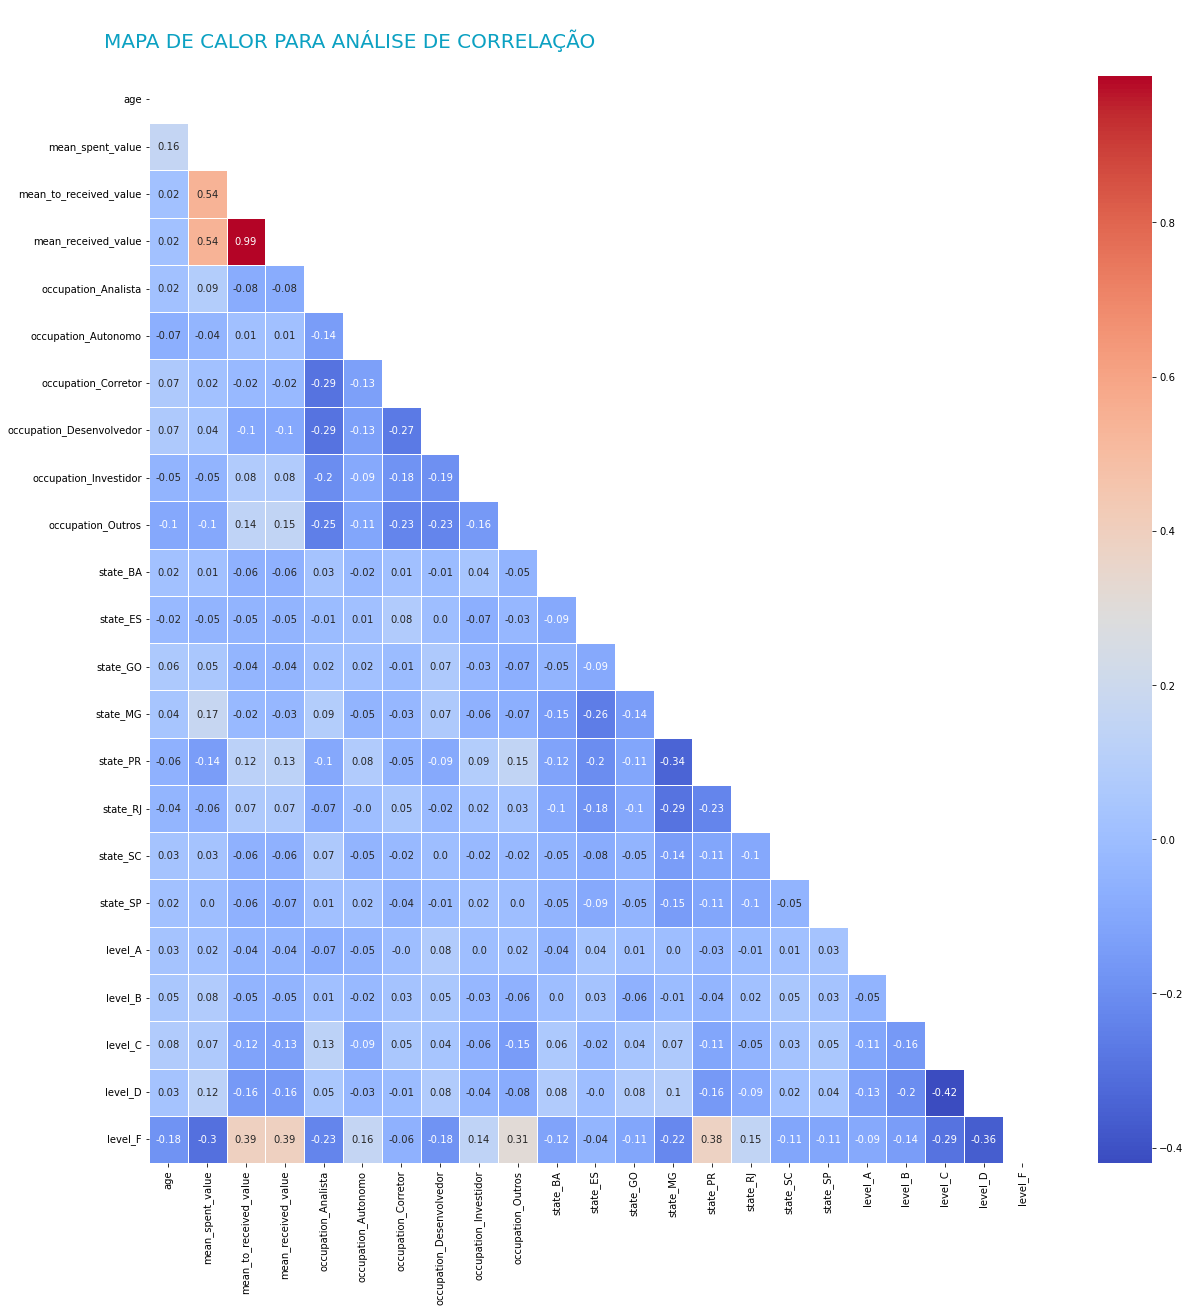

In [13]:
aux = ['occupation', 'state', 'level', 'age', 'mean_spent_value', 'mean_to_received_value', 'mean_received_value']

#tratar variáveis qualitativas
df_dim_encoding = df_dim[aux].copy()
df_dim_encoding = pd.get_dummies(df_dim_encoding)

#calcular correlação
data = df_dim_encoding.corr()

#criar gráfico
plt.figure(figsize=(20,20))

mask = np.zeros_like(data)
mask[np.triu_indices_from(mask)] = True

plt.title('\nMAPA DE CALOR PARA ANÁLISE DE CORRELAÇÃO\n', fontsize=20, color='#0CA1C2', ha='right')
sns.heatmap(data=data.round(2), mask=mask, annot=True, fmt= '.2', cmap='coolwarm', linewidths=.7)

plt.show()

**Pela análise de correlação acima podemos tirar algumas conclusões:**

- Existe uma tendência maior das contas ilícitas estarem localizadas nos estados do PR e RJ, tomemos atenção a estes dois;
- Aparentemente o estado de MG é o mais confiável;
- Devemos ter mais atenção também quando a pessoa autodeclara sua ocupação como 'Outros'. Existe um correlacionamento maior dessas pessoas a atividades suspeitas e, coincidentemente ou não, elas estão mais localizadas no PR;
- Analistas e Desenvolvedores tendem a ter menos suas contas suspendidas;
- A relação entre a idade e as contas classificadas com F é inversa, ou seja, contas ilícitas estão mais relacionadas a pessoas mais jovens;
- As contas da categoria B tendem a receber mais, indo de encontro ao esperado que era a categoria A. Ao que parece, a vantagem da categoria A é que ela é mais uniforme entre valores já recebidos e valores futuros a receber. Assim, além de serem a segunda melhor correlacionada aos recebimentos, são também mais previsíveis, podendo as tornar mais vantajosas;
- As contas classificadas como F tendem a ter um valor médio dos pix enviados menor;
- Em contas lícitas, os valores médios recebidos por pix e boletos e, valores médios dos boletos a receber, tendem a ser maiores.

**Abaixo podemos visualizar melhor estas informações:**

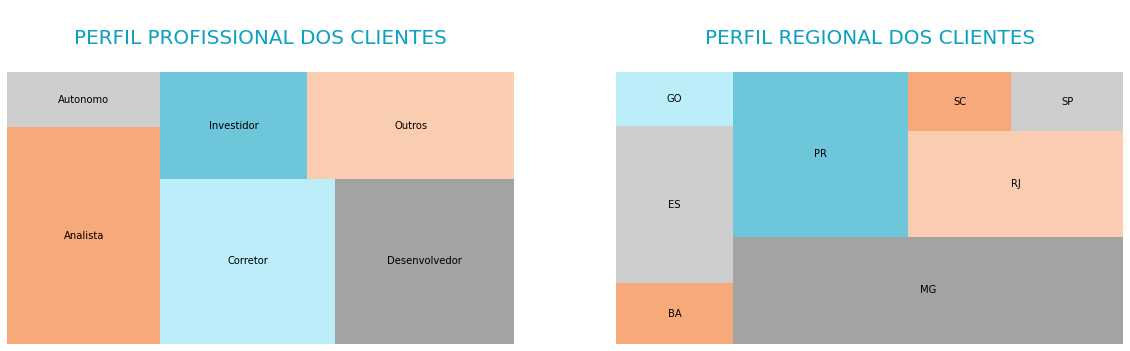

In [14]:
#####################################################################
def treemap(feature, ax):
    data = df_dim.groupby(feature).count().reset_index()[[feature, 'id']]
    color = ['#F37021', '#AEAEAE', '#90E4F8', '#666666', '#0CA1C2', '#F8AB7C']
    squarify.plot(ax=ax, sizes=data['id'], label=data[feature], color=color, alpha=.6) 
#####################################################################
fig, ax = plt.subplots(1, 2, figsize=(20,5))

ax[0].set_title('\nPERFIL PROFISSIONAL DOS CLIENTES\n', fontsize=20, color='#0CA1C2')
treemap('occupation', ax=ax[0])
ax[0].axis('off')

ax[1].set_title('\nPERFIL REGIONAL DOS CLIENTES\n', fontsize=20, color='#0CA1C2')
treemap('state', ax=ax[1])
ax[1].axis('off')

plt.show()

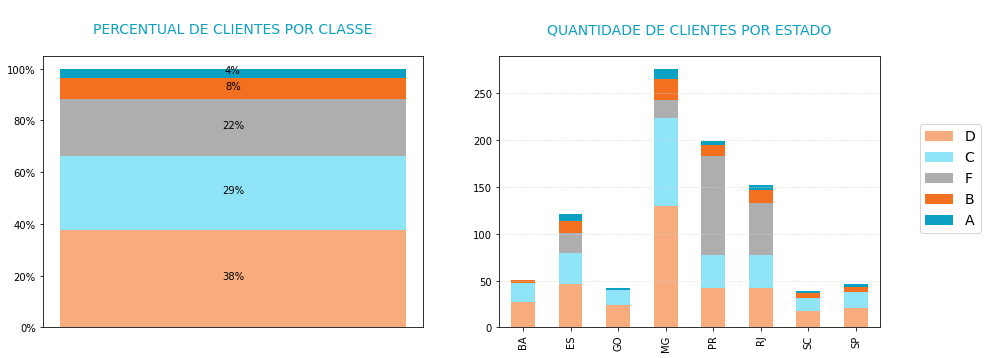

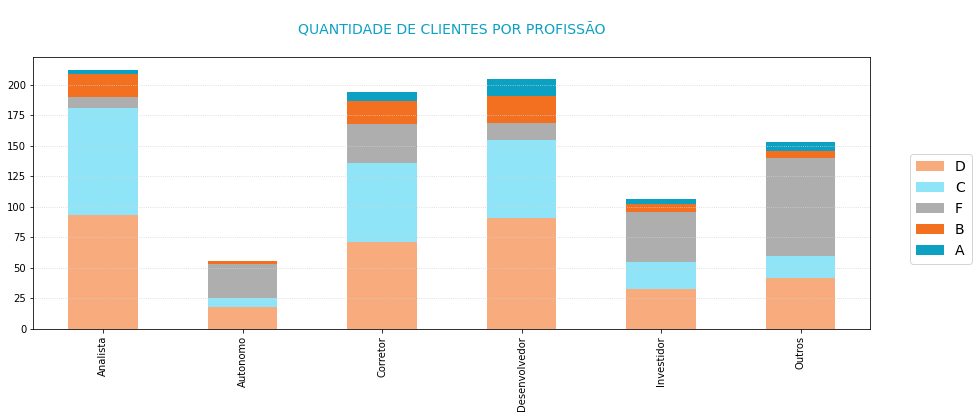

In [15]:
color = ['#F8AB7C', '#90E4F8', '#AEAEAE', '#F37021', '#0CA1C2']
class_contas = ['D', 'C', 'F', 'B', 'A']

fig, ax = plt.subplots(1, 2, figsize=(15,5))

aux= []
for i, classe in enumerate(class_contas):
    perc_class = (len(df_dim[df_dim['level'] == classe])/len(df_dim[df_dim['is_Fraud'].isin([1,0])]))*100
    aux.append(perc_class)
    ax[0].bar(x='Contas Classificadas', height=perc_class, bottom=sum(aux[:i]), color=color[i], label=classe)
ax[0].set_title('\nPERCENTUAL DE CLIENTES POR CLASSE\n', fontsize=14, color='#0CA1C2')   
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter())
for j, p in enumerate(ax[0].patches):
    height = p.get_height()
    ax[0].text(p.get_x()+p.get_width()/2., (sum(aux[:j+1])+sum(aux[:j]))/2, '{:.0%}'.format(height/100), ha='center')
ax[0].get_xaxis().set_visible(False)
fig.legend(loc='right', ncol=1, fontsize=14)


aux = pd.get_dummies(df_dim[['state', 'level']], columns=['level']).groupby('state').sum()
aux = aux[['level_D', 'level_C', 'level_F', 'level_B', 'level_A']]
x = aux.index
y_A = aux['level_A'].values
y_B = aux['level_B'].values
y_C = aux['level_C'].values
y_D = aux['level_D'].values
y_F = aux['level_F'].values
ax[1].set_title('\nQUANTIDADE DE CLIENTES POR ESTADO\n', fontsize=14, color='#0CA1C2')
aux.reset_index().plot(ax=ax[1], x='state', kind='bar', stacked=True, color=color, xlabel='', legend=False)
ax[1].grid(axis='y',linestyle='dotted', color='lightgrey')

plt.show()

####################################

fig, ax = plt.subplots(figsize=(15,5))

aux = pd.get_dummies(df_dim[['occupation', 'level']], columns=['level']).groupby('occupation').sum()
aux = aux[['level_D', 'level_C', 'level_F', 'level_B', 'level_A']]
aux = aux.rename(columns={'level_D':'D', 'level_C':'C', 'level_F':'F', 'level_B':'B', 'level_A':'A'})
x = aux.index
y_A = aux['A'].values
y_B = aux['B'].values
y_C = aux['C'].values
y_D = aux['D'].values
y_F = aux['F'].values
ax.set_title('\nQUANTIDADE DE CLIENTES POR PROFISSÃO\n', fontsize=14, color='#0CA1C2')
aux.reset_index().plot(ax=ax, x='occupation', kind='bar', stacked=True, color=color, xlabel='', legend=False)
ax.grid(axis='y',linestyle='dotted', color='lightgrey')
fig.legend(loc='right', ncol=1, fontsize=14)
plt.show()

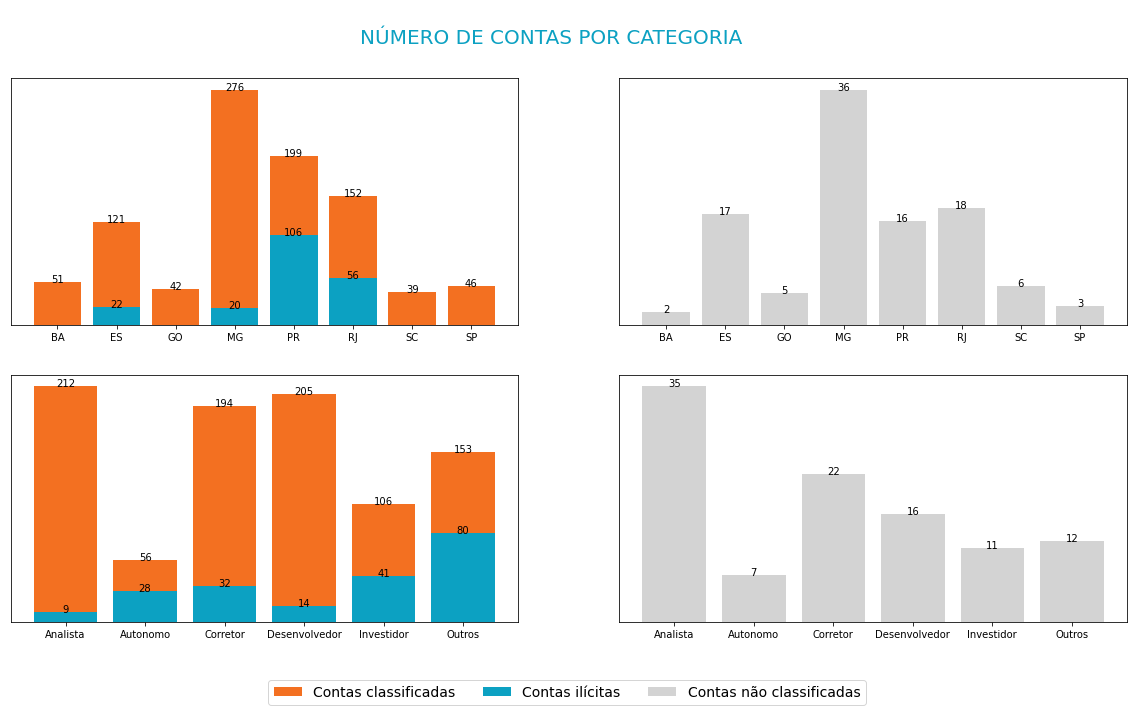

In [16]:
#####################################################################
def graph_contas(ax, groupby, filter_coluna, isin, color='#F37021', label=''):
    '''
    ax: posição do grafico ex: ax[0], ax[0,0], ax ou plt
    groupby (str): coluna de df_dim para agrupamento
    filter_coluna: coluna de df a ser filtrada
    isin (list): lista de valores contento os elemntos a serem filtrados em filter_coluna
    '''
    ax.bar(x=df_dim[df_dim[filter_coluna].isin(isin)].groupby(groupby).count().index,
        height=df_dim[df_dim[filter_coluna].isin(isin)].groupby(groupby).count()['id'].values,
        color=color, label=label)
#####################################################################    

fig, ax = plt.subplots(2, 2, figsize=(20,10))
fig.suptitle('\nNÚMERO DE CONTAS POR CATEGORIA', fontsize=20, color='#0CA1C2')
ax = ax.flatten()

graph_contas(ax[0], 'state', 'is_Fraud',[1,0],'#F37021', 'Contas classificadas')
graph_contas(ax[0], 'state', 'is_Fraud', [1],'#0CA1C2', 'Contas ilícitas')
graph_contas(ax[1], 'state', 'is_Fraud', [np.NaN],'lightgrey', 'Contas não classificadas')
graph_contas(ax[2], 'occupation', 'is_Fraud', [1,0],'#F37021')
graph_contas(ax[2], 'occupation', 'is_Fraud', [1],'#0CA1C2')
graph_contas(ax[3], 'occupation', 'is_Fraud', [np.NaN],'lightgrey')

#rotular gráficos
for grafico in ax:
    grafico.get_yaxis().set_visible(False)
    for p in grafico.patches:
        height = p.get_height()
        grafico.text(p.get_x()+p.get_width()/2., height, '{:,.0f}'.format(height), ha='center')

fig.legend(loc='lower center', ncol=3, fontsize=14)
fig.show()

<br>
<br>

**Além da correlação das contas classe F com os estados, podemos analisar também a nível municipal. Vamos ver as cidades com 
mais índice de fraudes:**

In [17]:
#calcular cidades com mais fraudes
cidades = df_dim.groupby('city').sum().sort_values('is_Fraud', ascending=False).index
total_fraudes = df_dim.groupby('city').sum().sort_values('is_Fraud', ascending=False)['is_Fraud'].values

fraudes_cidade = pd.DataFrame(total_fraudes, index=cidades).rename(columns={0: 'Total Fraudes'})
fraudes_cidade['% Fraudes'] = (fraudes_cidade['Total Fraudes']/fraudes_cidade['Total Fraudes'].sum())*100

fraudes_cidade = fraudes_cidade.join(df_address[['state', 'city']].set_index('city'), on='city', how='left')

top5_problemas = fraudes_cidade.sort_values('% Fraudes', ascending=False)[:5]
print('\nTop5 Cidades com Mais Fraudes:')
display(top5_problemas)


Top5 Cidades com Mais Fraudes:


,Total Fraudes,% Fraudes,state
city,,,
Mangaratiba,4.0,1.960784,RJ
Jesuitas,3.0,1.470588,PR
Boa Esperanca do Iguacu,3.0,1.470588,PR
Engenheiro Paulo de Frontin,3.0,1.470588,RJ
Italva,3.0,1.470588,RJ


Podemos notar que das 5 cidades com mais contas classe F, 3 estão no estado do RJ e 2 estão no estado de PR. Isso reforça nossos indícios anteriores. Porém, dá pra se reparar também que, a nível municipal não parece haver muita relação, pelo fato de o número de ocorrências totais, 204, estar bastante distribuída municipalmente.

<br>
<br>

**Sobre a relação da idade com as contas ilícitas, abaixo podemos observar que, enquanto nosso público estudado possui idades entre 18 e 67 anos, as contas ilícitas foram identificadas num grupo menor que possui entre 22 e 47 anos, sendo a grande maioria entre 29 e 39 anos.**

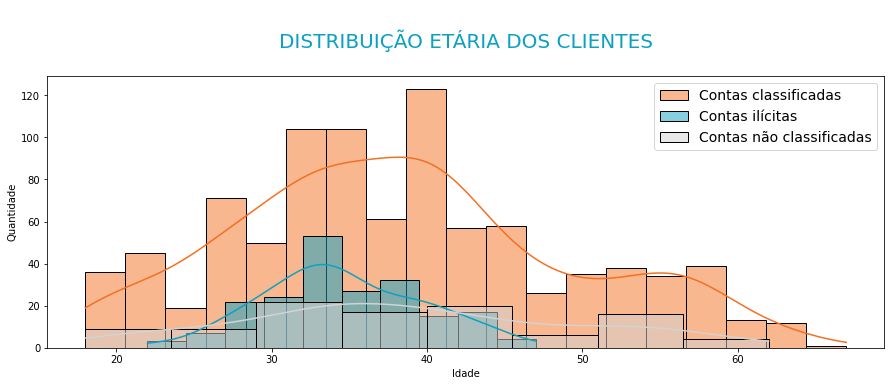

In [18]:
plt.figure(figsize=(15,5))
plt.title('\nDISTRIBUIÇÃO ETÁRIA DOS CLIENTES\n', fontsize=20, color='#0CA1C2')
sns.histplot(data=df_dim[df_dim['is_Fraud'].isin([0,1])]['age'], color='#F37021', kde=True, label='Contas classificadas')
sns.histplot(data=df_dim[df_dim['is_Fraud']==1]['age'], color='#0CA1C2', kde=True, label='Contas ilícitas')
sns.histplot(data=df_dim[df_dim['is_Fraud'].isnull()]['age'], color='lightgrey', kde=True, label='Contas não classificadas')
plt.ylabel('Quantidade')
plt.xlabel('Idade')
plt.legend(loc='upper right', ncol=1, fontsize=14)
plt.show()

<br>
<br>

**Análise das Transações:**

Como tivemos indícios que os valores médios das transações estão correlacionados as contas classe F, outra observação importante que pode ser feita é sobre os valores emitidos nos boletos e suas transações efetivadas, tentando entender melhor a diferença destas movimentações entre os clientes que possuem contas lícitas e ilícitas.

**Abaixo temos a visualização gráfica destas informações através de boxplots e podemos notar que:**

**Valores dos boletos (não recebidos/recebidos) e pix recebidos:**

Estes três gráficos são muito parecidos, podendo tirar as mesmas conclusões.

- Nas contas classificadas como F a mediana dos valores fica próximo a 8.000 enquanto nas outras classes gira entorno de 5.000, 60% abaixo;
- Enquanto nas contas ilícitas os valores destes boletos chegam a quase 14.000, nas contas lícitas valores acima de 9.000 são considerados como exceções, 55% abaixo.

**Valores dos pix enviados:**

- Enquanto nos outros três gráficos podemos reparar que os valores das transações nas contas classe F são maiores que nas demais, aqui já podemos perceber o contrário. Nas contas ilícitas os valores retirados atingem um máximo de 150.000, acima disso pode ser considerado como valores fora do padrão, com estes não chegando a 400.000. Já nas contas classe A, B, C e D, os valores retirados, normalmente, são de até 300.000. Podendo ultrapassar os 900.000. 


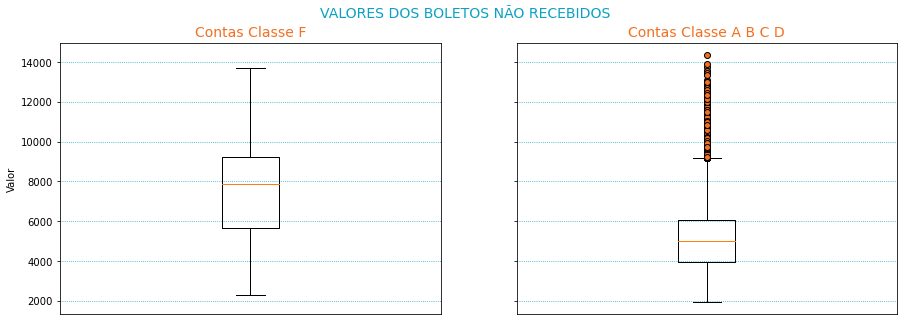

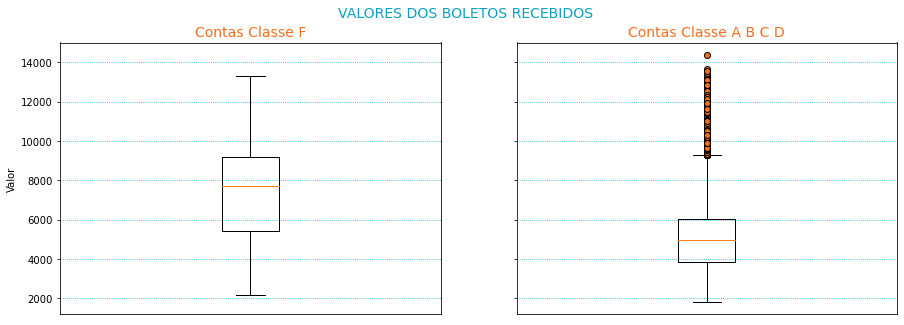

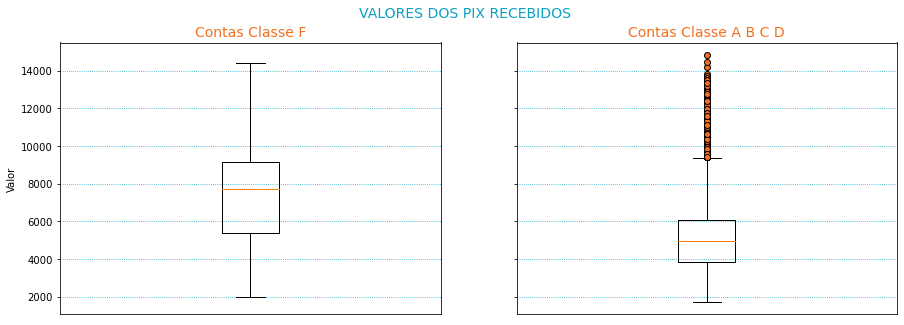

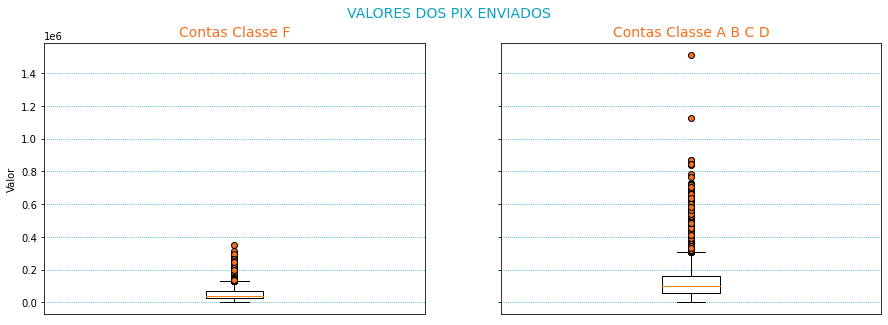

In [19]:
fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
fig.suptitle('VALORES DOS BOLETOS NÃO RECEBIDOS', fontsize=14, color='#0CA1C2')

data1 = df[(df['is_Fraud']==1) & (df['description']=='boleto_nao_recebido')]
data2 = df[(df['is_Fraud']==0) & (df['description']=='boleto_nao_recebido')]

ax[0].set_title('Contas Classe F', fontsize=14, color='#F37021')
ax[0].boxplot(data1['value'], flierprops={'markerfacecolor':'#F37021'})
ax[0].get_xaxis().set_visible(False)
ax[0].set_ylabel('Valor')
ax[0].grid(axis='y',linestyle='dotted', color='#0CA1C2')

ax[1].set_title('Contas Classe A B C D', fontsize=14, color='#F37021')
ax[1].boxplot(data2['value'], flierprops={'markerfacecolor':'#F37021'})
ax[1].get_xaxis().set_visible(False)
ax[1].grid(axis='y',linestyle='dotted', color='#0CA1C2')

plt.show()

##########################################

fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
fig.suptitle('VALORES DOS BOLETOS RECEBIDOS', fontsize=14, color='#0CA1C2')

data3 = df[(df['is_Fraud']==1) & (df['description']=='boleto_recebido')]
data4 = df[(df['is_Fraud']==0) & (df['description']=='boleto_recebido')]

ax[0].set_title('Contas Classe F', fontsize=14, color='#F37021')
ax[0].boxplot(data3['value'], flierprops={'markerfacecolor':'#F37021'})
ax[0].get_xaxis().set_visible(False)
ax[0].set_ylabel('Valor')
ax[0].grid(axis='y',linestyle='dotted', color='#0CA1C2')

ax[1].set_title('Contas Classe A B C D', fontsize=14, color='#F37021')
ax[1].boxplot(data4['value'], flierprops={'markerfacecolor':'#F37021'})
ax[1].get_xaxis().set_visible(False)
ax[1].grid(axis='y',linestyle='dotted', color='#0CA1C2')

plt.show()

##########################################

fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
fig.suptitle('VALORES DOS PIX RECEBIDOS', fontsize=14, color='#0CA1C2')

data5 = df[(df['is_Fraud']==1) & (df['description']=='pix_recebido')]
data6 = df[(df['is_Fraud']==0) & (df['description']=='pix_recebido')]

ax[0].set_title('Contas Classe F', fontsize=14, color='#F37021')
ax[0].boxplot(data5['value'], flierprops={'markerfacecolor':'#F37021'})
ax[0].get_xaxis().set_visible(False)
ax[0].set_ylabel('Valor')
ax[0].grid(axis='y',linestyle='dotted', color='#0CA1C2')

ax[1].set_title('Contas Classe A B C D', fontsize=14, color='#F37021')
ax[1].boxplot(data6['value'], flierprops={'markerfacecolor':'#F37021'})
ax[1].get_xaxis().set_visible(False)
ax[1].grid(axis='y',linestyle='dotted', color='#0CA1C2')

plt.show()

##########################################

fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
fig.suptitle('VALORES DOS PIX ENVIADOS', fontsize=14, color='#0CA1C2')

data7 = df[(df['is_Fraud']==1) & (df['description']=='pix_enviado')]
data8 = df[(df['is_Fraud']==0) & (df['description']=='pix_enviado')]

ax[0].set_title('Contas Classe F', fontsize=14, color='#F37021')
ax[0].boxplot(data7['value'], flierprops={'markerfacecolor':'#F37021'})
ax[0].get_xaxis().set_visible(False)
ax[0].set_ylabel('Valor')
ax[0].grid(axis='y',linestyle='dotted', color='#0CA1C2')

ax[1].set_title('Contas Classe A B C D', fontsize=14, color='#F37021')
ax[1].boxplot(data8['value'], flierprops={'markerfacecolor':'#F37021'})
ax[1].get_xaxis().set_visible(False)
ax[1].grid(axis='y',linestyle='dotted', color='#0CA1C2')

plt.show()

<br>
<br>

**Como nossa análise se deu com a presença de outliers, vamos realizar a mesma investigação porém, agora, excluindo estes dados considerados acima como fora do padrão.** 

Abaixo temos esta nova visualização:

In [20]:
#analisar outliers
######################################
def limites(coluna):
    '''
    
    Função que retorna os limites mínimos e máximos, para identificar os outliers.
    
    '''
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    lim_inf = q1 - 1.5 * amplitude
    lim_sup = q3 + 1.5 * amplitude
    return lim_inf, lim_sup
######################################
def excluir_outliers(df, nome_coluna):
    '''
    
    Função que exclui os outliers identificados abaixo do limite inferior ou acima do limite superior
    
    '''
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    return df
######################################

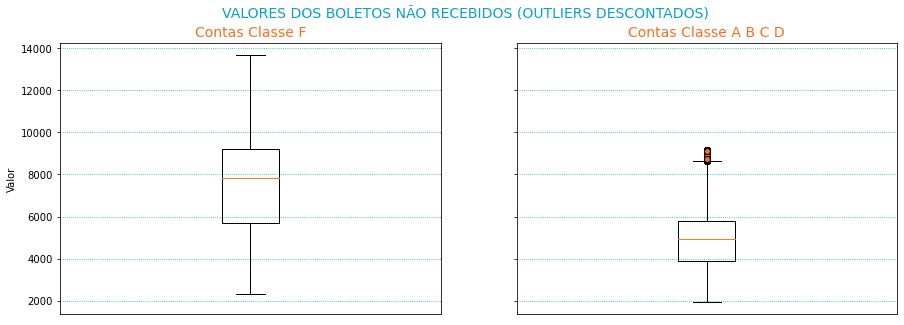

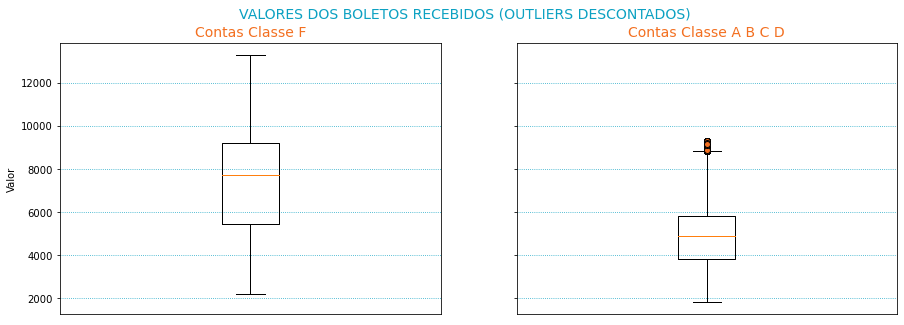

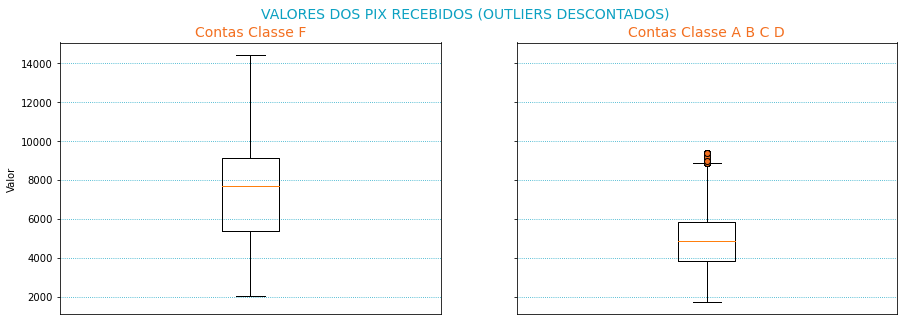

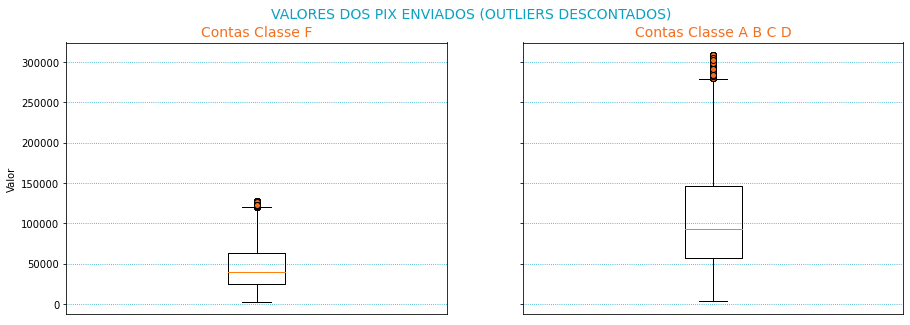

In [21]:
data1 = excluir_outliers(data1, 'value')
data2 = excluir_outliers(data2, 'value')
data3 = excluir_outliers(data3, 'value')
data4 = excluir_outliers(data4, 'value')
data5 = excluir_outliers(data5, 'value')
data6 = excluir_outliers(data6, 'value')
data7 = excluir_outliers(data7, 'value')
data8 = excluir_outliers(data8, 'value')


fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
fig.suptitle('VALORES DOS BOLETOS NÃO RECEBIDOS (OUTLIERS DESCONTADOS)', fontsize=14, color='#0CA1C2')

ax[0].set_title('Contas Classe F', fontsize=14, color='#F37021')
ax[0].boxplot(data1['value'], flierprops={'markerfacecolor':'#F37021'})
ax[0].get_xaxis().set_visible(False)
ax[0].set_ylabel('Valor')
ax[0].grid(axis='y',linestyle='dotted', color='#0CA1C2')

ax[1].set_title('Contas Classe A B C D', fontsize=14, color='#F37021')
ax[1].boxplot(data2['value'], flierprops={'markerfacecolor':'#F37021'})
ax[1].get_xaxis().set_visible(False)
ax[1].grid(axis='y',linestyle='dotted', color='#0CA1C2')

plt.show()

##########################################

fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
fig.suptitle('VALORES DOS BOLETOS RECEBIDOS (OUTLIERS DESCONTADOS)', fontsize=14, color='#0CA1C2')

ax[0].set_title('Contas Classe F', fontsize=14, color='#F37021')
ax[0].boxplot(data3['value'], flierprops={'markerfacecolor':'#F37021'})
ax[0].get_xaxis().set_visible(False)
ax[0].set_ylabel('Valor')
ax[0].grid(axis='y',linestyle='dotted', color='#0CA1C2')

ax[1].set_title('Contas Classe A B C D', fontsize=14, color='#F37021')
ax[1].boxplot(data4['value'], flierprops={'markerfacecolor':'#F37021'})
ax[1].get_xaxis().set_visible(False)
ax[1].grid(axis='y',linestyle='dotted', color='#0CA1C2')

plt.show()

##########################################

fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
fig.suptitle('VALORES DOS PIX RECEBIDOS (OUTLIERS DESCONTADOS)', fontsize=14, color='#0CA1C2')

ax[0].set_title('Contas Classe F', fontsize=14, color='#F37021')
ax[0].boxplot(data5['value'], flierprops={'markerfacecolor':'#F37021'})
ax[0].get_xaxis().set_visible(False)
ax[0].set_ylabel('Valor')
ax[0].grid(axis='y',linestyle='dotted', color='#0CA1C2')

ax[1].set_title('Contas Classe A B C D', fontsize=14, color='#F37021')
ax[1].boxplot(data6['value'], flierprops={'markerfacecolor':'#F37021'})
ax[1].get_xaxis().set_visible(False)
ax[1].grid(axis='y',linestyle='dotted', color='#0CA1C2')

plt.show()

##########################################

fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
fig.suptitle('VALORES DOS PIX ENVIADOS (OUTLIERS DESCONTADOS)', fontsize=14, color='#0CA1C2')

ax[0].set_title('Contas Classe F', fontsize=14, color='#F37021')
ax[0].boxplot(data7['value'], flierprops={'markerfacecolor':'#F37021'})
ax[0].get_xaxis().set_visible(False)
ax[0].set_ylabel('Valor')
ax[0].grid(axis='y',linestyle='dotted', color='#0CA1C2')

ax[1].set_title('Contas Classe A B C D', fontsize=14, color='#F37021')
ax[1].boxplot(data8['value'], flierprops={'markerfacecolor':'#F37021'})
ax[1].get_xaxis().set_visible(False)
ax[1].grid(axis='y',linestyle='dotted', color='#0CA1C2')

plt.show()

<br>
<br>

**Podemos notar que com a exclusão destes outliers, a distribuição em nosso boxplot se manteve bastante semelhante. Manteremos então as mesmas observações feitas anteriormente.**

<div style="color:#F37021; font-size:150%; text-align:left; border-radius:5px">
    <h4><u> CRIAR MODELO PREDITIVO </u></h4>
</div>

Terminada a exploração dos dados, já temos agora informações suficientes para desenvolvimento de um modelo de aprendizado supervisionado para identificação das contas lícitas e ilícitas ainda não classificadas em levels. <br>

Vamos preparar os dados para criação do modelo. Inicialmente separaremos os dados para teste, treino e validação em variáveis independentes (x) e variável dependente (y), ajustaremos as variáveis qualitativas existentes, padronizaremos e balancearemos os dados.

**Separar, Padronizar e Balancear os Dados:**

In [22]:
#separar variavel dependente das independentes
selecao_recursos = ['occupation','address_id','state','age','mean_spent_value','mean_to_received_value','mean_received_value']
df_ml = df_dim.dropna()
x = df_ml[selecao_recursos]
y = df_ml['is_Fraud']

#tratar variáveis qualitativas
x = pd.get_dummies(x)
x_columns = x.columns

#padronizar dados
scaler = StandardScaler()
x_standard = scaler.fit_transform(x)

#separar dados de treino, teste e validação
x_treino, x_teste, y_treino, y_teste = train_test_split(x_standard, y, test_size=0.3, random_state=1)
x_val, x_teste, y_val, y_teste = train_test_split(x_teste, y_teste, test_size=0.5, random_state=1)

In [23]:
print(f'Tamanho dos Dados de Treino: {len(x_treino)}')
print(f'Tamanho dos Dados de Teste: {len(x_teste)}')
print(f'Tamanho dos Dados de Validação: {len(x_val)}')

Tamanho dos Dados de Treino: 648
Tamanho dos Dados de Teste: 139
Tamanho dos Dados de Validação: 139


O **balanceamento** dos dados aqui visa equilibrar o número de contas lícitas e ilícitas. Utilizamos aqui de uma técnica para **oversampling na base de dados para treino**, assim, nosso modelo terá mais dados de treino para identificar as características das contas ilícitas.

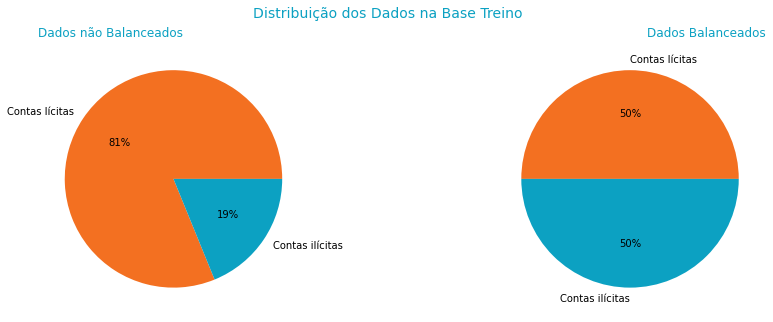

Tamanho dos Dados de Treino Balanceados: 1052


In [24]:
balanceamento_over = SMOTE(random_state=1)
x_bal, y_bal = balanceamento_over.fit_resample(x_treino, y_treino)

fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle('Distribuição dos Dados na Base Treino', fontsize=14, color='#0CA1C2')

ax[0].set_title('Dados não Balanceados', fontsize=12, color='#0CA1C2', loc='left')
ax[0].pie(x=y_treino.value_counts().values, 
        labels = ['Contas lícitas', 'Contas ilícitas'], colors = ['#F37021', '#0CA1C2'], autopct='%.0f%%')

ax[1].set_title('Dados Balanceados', fontsize=12, color='#0CA1C2', loc='right')
ax[1].pie(x=y_bal.value_counts().values, 
        labels = ['Contas lícitas', 'Contas ilícitas'], colors = ['#F37021', '#0CA1C2'], autopct='%.0f%%')

plt.show()

print(f'Tamanho dos Dados de Treino Balanceados: {len(x_bal)}')

<br>
<br>

Para criação do modelo, testaremos inicialmente cinco algoritmos diferentes para escolhermos um que melhor resultado nos entregue. Os algoritmos analisados serão: **Random Forest, Suport Vector Machine, Logistic Regression, K Neighbor Nearest e Gradient Booster**.

**Vamos analisar os resultados obtidos**:

In [25]:
randomforest = RandomForestClassifier(random_state=1)
suportvectormachine = svm.SVC(random_state=1)
regressaologistica = LogisticRegression(random_state=1)
knn = KNeighborsClassifier()
gradientboosting = GradientBoostingClassifier(random_state=1)

modelos_classificacao = {'Random Forest': randomforest, 'Supor Vector Machine': suportvectormachine,
                         'Logistic Regression': regressaologistica, 'K Nearest Neighbor': knn,
                         'Gradient Boosting': gradientboosting}

for nome_modelo, modelo in modelos_classificacao.items():
    modelo.fit(x_bal, y_bal)
    y_pred = modelo.predict(x_teste)
    print(f'\n\nRelatório de Classificação {nome_modelo}:\n\n',classification_report(y_teste, y_pred))



Relatório de Classificação Random Forest:

               precision    recall  f1-score   support

         0.0       0.94      0.97      0.95        97
         1.0       0.92      0.86      0.89        42

    accuracy                           0.94       139
   macro avg       0.93      0.91      0.92       139
weighted avg       0.93      0.94      0.93       139



Relatório de Classificação Supor Vector Machine:

               precision    recall  f1-score   support

         0.0       0.93      0.95      0.94        97
         1.0       0.88      0.83      0.85        42

    accuracy                           0.91       139
   macro avg       0.90      0.89      0.90       139
weighted avg       0.91      0.91      0.91       139



Relatório de Classificação Logistic Regression:

               precision    recall  f1-score   support

         0.0       0.97      0.96      0.96        97
         1.0       0.91      0.93      0.92        42

    accuracy                   

**Existem duas situações importantes neste nosso problema:**

**1ª)**  A identificação errada de uma conta como ilícita, suspende a conta de um cliente injustamente. Isso gera um impacto negativo para a imagem da empresa e para a operação, que diminui sua captação. Para medir esta situação, onde o **custo dos Falso Positivo são altos, Precision é uma boa métrica de desempenho do modelo**;


**2ª)**  A não identificação das contas ilícitas gera para a empresa uma perda de credibilidade muito grande, podendo gerar uma associação entre a marca e fraudes bancárias. Assim, neste caso temos também um **alto custo dos Falsos Negativos, e uma métrica melhor para esta situação seria o Recall**.

<br>

Como teremos de buscar atender as duas situações, analisar a ponderação entre Reccal e Precision em F1-Score, juntamente da Acucuracy do modelo, pode ser uma melhor ideia para avaliação dos resultados. Sendo assim, podemos observar que **Logistic Regression** teve a melhor acuracidade, com 95%. <br>
Além de uma performance geral melhor, da para perceber também que ele se destaca em todos os outros indicadores. Por este motivo seguiremos adiante com a utilização deste modelo.

<br>

Como inicialmente padronizamos nossos dados, fica agora possível um melhor entendimento da **importância de cada característica dentro do modelo**, pois conseguimos ver o peso de cada uma sem o viés de sua dimensionalidade.

**Abaixo temos esta visualização**: <br> 

A ponderação da importância será dada através do módulo do coeficiente de importância, pois, seu sinal é apenas um indicador da classificação. Ou seja, quanto maior ou menor o valor do coeficiente, maior será a probabilidade de a conta ser ilícita ou lícita, respectivamente.

In [26]:
def feature_importance(data, x):
    feature_importances = pd.DataFrame(data=data, columns=x_columns).transpose()
    feature_importances = feature_importances.rename(columns={0: 'Coeficiente de Importancia'})
    feature_importances['Ponderação (%) da Importancia'] = ((abs(feature_importances)/abs(feature_importances).sum())*100).round(0)
    feature_importances = feature_importances.sort_values(by='Ponderação (%) da Importancia', ascending=False)
    return display(feature_importances)

feature_importance(regressaologistica.coef_, x)

,Coeficiente de Importancia,Ponderação (%) da Importancia
mean_spent_value,-4.803015,32.0
mean_to_received_value,1.954274,13.0
mean_received_value,1.722233,11.0
state_PR,0.937834,6.0
state_SP,-0.788598,5.0
occupation_Analista,-0.534983,4.0
state_SC,-0.533541,4.0
age,-0.635349,4.0
occupation_Outros,0.548016,4.0
occupation_Autonomo,0.431877,3.0


<br>
<br>

**As três características mais relevante pro modelo classificar foram situações já descritas aqui:**

- Quanto menor os valores sacados por pix, maior a chance destas transações estarem ligadas a uma conta ilícita. Esta foi a característica mais relevante para o modelo identificar as contas suspeitas;


- As próximas duas características mais relevantes também são referentes aos valores das transações. Quanto maior os valores recebidos ou a receber, maiores as chances de as contas serem ilícitas.
<br>
<br>

**Agora, vamos aplicar nosso modelo nos dados de validação, ainda desconhecidos, e verificar os resultados obtidos. Assim podemos detectar um possível overfitting/underfitting:**

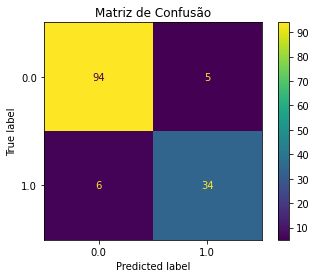



Relatório de Classificação (Logistic Regression):

               precision    recall  f1-score   support

         0.0       0.94      0.95      0.94        99
         1.0       0.87      0.85      0.86        40

    accuracy                           0.92       139
   macro avg       0.91      0.90      0.90       139
weighted avg       0.92      0.92      0.92       139



In [27]:
y_pred_val = regressaologistica.predict(x_val)
y_pred_prob_val = regressaologistica.predict_proba(x_val)

grafico = ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred_val), display_labels=regressaologistica.classes_)
grafico.plot()
plt.title('Matriz de Confusão')
plt.show()

print(f'\n\nRelatório de Classificação (Logistic Regression):\n\n',classification_report(y_val, y_pred_val))

**Nosso modelo de Regressão Logística final leva em consideração sete características para classificação das contas.**

São elas:

**1)** Tipo de negócio autodeclarado pelo cliente; <br>
**2)** Código da cidade do cliente; <br>
**3)** Estado do cliente; <br>
**4)** Idade do cliente; <br>
**5)** Valor médio dos pix enviados pela conta; <br>
**6)** Valor médio dos boletos a receber da conta; <br>
**7)** Valor médio dos pix e boletos recebidos da conta. <br>

**O resultado obtido foi:**

- Identificação de 34 dos 40 clientes (85%) que possuíam contas classificadas como F;


- Acusação errada de 5 contas que não eram classe F como sendo. Este erro representa 5% dos clientes analisados.


- Modelo final atingiu uma precisão geral de 92% de acuracidade.

Um resultado consideravelmente bom se comparado aos resultados do teste.
<br>
<br>

**Podemos ainda analisar em quais contas o modelo errou nos dados de validação e tentar entender o motivo:**

In [28]:
#verificar contas que a previsão errou
aux = []
for i, resposta in enumerate(y_val):
    if resposta != y_pred_val[i]:
        aux.append(i)
        
indice_erro_pred = []
y_prob_0_val = []
y_prob_1_val = []
for indice in aux:
    indice_erro_pred.append(y_val.index[indice])
    y_prob_0_val.append(y_pred_prob_val[indice][0])
    y_prob_1_val.append(y_pred_prob_val[indice][1])
    
verificacao = df_dim.iloc[indice_erro_pred]
verificacao = verificacao[['account_number','occupation','state','city','level','age',
                           'mean_spent_value','mean_to_received_value','mean_received_value']]
verificacao['prob_class_0'] = y_prob_0_val
verificacao['prob_class_1'] = y_prob_1_val
verificacao = verificacao.sort_values('level')

print('\nCaracterísticas das {} contas classificadas como lícitas e ilícitas erradas:'.format(len(verificacao)))
display(verificacao)


Características das 11 contas classificadas como lícitas e ilícitas erradas:


,account_number,occupation,state,city,level,age,mean_spent_value,mean_to_received_value,mean_received_value,prob_class_0,prob_class_1
272,670007,Investidor,MG,Nova Belem,C,18,53052.727273,4859.941176,4986.476510,0.339016,0.660984
854,840368,Autonomo,RJ,Aperibe,C,30,38093.363636,4354.868852,4398.936937,0.074423,0.925577
991,807641,Outros,RJ,Porciuncula,D,18,45793.000000,5104.750000,4858.051282,0.047436,0.952564
295,34511,Analista,PR,Cafeara,D,35,53634.333333,5442.742188,5424.666667,0.327288,0.672712
1005,757584,Desenvolvedor,MG,Pavao,D,55,0.000000,4919.400000,5007.291667,0.461415,0.538585
92,54143,Desenvolvedor,ES,Serra,F,41,18539.730769,4328.780000,4335.415254,0.712841,0.287159
440,212154,Analista,PR,Espigao Alto do Iguacu,F,33,0.000000,0.000000,0.000000,0.922607,0.077393
216,30978,Outros,ES,Nova Venecia,F,41,0.000000,0.000000,0.000000,0.937134,0.062866
137,261886,Outros,ES,Marechal Floriano,F,34,130610.076923,8303.720000,8344.090047,0.663642,0.336358
648,109613,Autonomo,ES,Ibatiba,F,39,0.000000,0.000000,0.000000,0.917901,0.082099


<br>
<br>

**Das contas classificadas erradas:**

Das 5 contas classificadas como ilícitas pelo modelo mesmo não sendo:

- 3 eram classe D e 2 classe C;
- 3 contas (670007, 34511, 757584) foram elegidas como ilícitas com uma confiança de 66%, 67% e 53%. Sabendo que a classificação se dá em 50%, podemos notar que não existia muita certeza na classificação;
- 2 contas (840368, 807641) possuíam características fortes de contas ilícitas. Autodeclaração de ocupação era de 'Autonomo' e 'Outros' as duas mais correlacionadas com as contas suspeitas, ambas eram do RJ, segundo estado com mais índice de contas fraudulentas e possuíam 30 e 18 anos.

Das 6 contas classificadas como lícitas pelo modelo sendo da classe F:

- 3 contas (212154, 30978, 109613) não possuíam nenhuma transação;
- 3 contas (54143, 261886, 701817) foram elegidas como lícitas com probabilidade próxima 70%.
<br>
<br>

Pelos fatos descritos podemos também chegar à conclusão que além da classificação como lícita ou ilícita, a análise da probabilidade de classificação também pode ajudar a esclarecer possíveis equívocos de classificações incorretas. Um estudo mais aprofundado pode ajudar a melhorar a acuracidade do modelo.

<div style="color:#F37021; font-size:150%; text-align:left; border-radius:5px">
    <h4><u> CLASSIFICAR CONTAS </u></h4>
</div>

Agora, como temos nosso modelo criado, **podemos classificar todas as contas presentes no banco de dados que não possuem classificação** na tabela levels.

Feito isso, geraremos um arquivo csv chamado **"contas_classificadas.csv"** com as colunas account_number e fraud, sendo o valor 0 para contas lícitas e 1 para contas ilícitas.

**Então**:

In [29]:
#definir contas a serem classificadas
classificar_contas = df_dim[df_dim['is_Fraud'].isin([np.NaN])][selecao_recursos]

#tratar variaveis qualitativas
classificar_contas = pd.get_dummies(classificar_contas)

#padronizar dados das contas a serem classificadas
x_bal_inverse = scaler.inverse_transform(x_bal)
x_bal_inverse = pd.DataFrame(x_bal_inverse, columns=x_columns)
mean = x_bal_inverse.describe()[1:2]
std = x_bal_inverse.describe()[2:3]
for coluna in classificar_contas.columns:
    classificar_contas[coluna] = (classificar_contas[coluna] - mean[coluna].values) / std[coluna].values

#fazer previsão
y_pred_cl = regressaologistica.predict(classificar_contas)
y_pred_prob_cl = regressaologistica.predict_proba(classificar_contas)

#criar dataframe com as contas agora classificadas
contas_classificadas = classificar_contas.copy()
contas_classificadas['fraud'] = y_pred_cl

prob_0_cl = []
prob_1_cl = []
for prob in y_pred_prob_cl:
    prob_0_cl.append(prob[0])
    prob_1_cl.append(prob[1])
contas_classificadas['prob_0'] = prob_0_cl
contas_classificadas['prob_1'] = prob_1_cl

contas_classificadas['account_number'] = df_dim[df_dim.index.isin(contas_classificadas.index)]['account_number'].values

#criar arquivo csv com numero da conta e classificação
contas_classificadas[['account_number', 'fraud']].to_csv('../dados/contas_classificadas.csv', index=False)

<br>
<br>

Complementando a classificação feita acima, podemos ainda disponibilizar as contas que não foram classificadas com uma probabilidade muito grande. Como comentado anteriormente, contas com classificação inferior a 70% de probabilidade de certeza, podem gerar alguma dúvida quanto a sua classe. 

Por isso vamos criar um alerta referente a estas contas:

In [30]:
averiguar_classificacao = contas_classificadas[(contas_classificadas['prob_0']<=0.7) & (contas_classificadas['prob_0']>=0.3)]
averiguar_classificacao = averiguar_classificacao[['account_number', 'fraud', 'prob_0', 'prob_1']]
print('\nAlerta a classificação das contas:')
display(averiguar_classificacao)


Alerta a classificação das contas:


,account_number,fraud,prob_0,prob_1
198,416638,1.0,0.344075,0.655925
374,910936,1.0,0.486807,0.513193
1010,354382,0.0,0.648801,0.351199


**Dentre todas as 103 contas classificadas em "contas_classificadas.csv" as que merecem atenção quanto a sua classe são as contas:**

- **416638**: Classificada como ilícita com apenas 65%


- **910936**: Classificada como ilícita com apenas 51%


- **354382**: Classificada como lícita com apenas 64%

<div style="color:#F37021; font-size:150%; text-align:left; border-radius:5px">
    <h4><u> ESCALAR MODELO </u></h4>
</div>

Para escalar a solução proposta, salvaremos em um banco SQLite os dados tratados necessários para reutilização do modelo e também, salvaremos um arquivo joblib para criar uma pipeline leve, afim de aproveitar o aprendizado de máquina já treinado e ganhar eficiência na implementação da RestAPI em produção.

In [31]:
#salvar dados tratados e padronizados
con = sqlite3.connect('../api/dados-treino.db')
df_dim.to_sql('df_dim', con, if_exists='replace')
classificar_contas.to_sql('classificar_contas', con, if_exists='replace')

#salvar pipeline do modelo
joblib.dump(regressaologistica, '../api/regressaologistica.joblib')

print('\nArquivos Salvos em:\n\n../api/dados-treino.db\n../api/regressaologistica.joblib')


Arquivos Salvos em:

../api/dados-treino.db
../api/regressaologistica.joblib
